
# Project: No-show Appointments Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project we'll be analyzing data associated with medical appointment records in Brazil. In particular, we'll be interested in finding the trends among the patients who showed up for their appointments and how they differ from the patients who didn't show up.

There are multiple factors in the dataset to analyze. However, I've chosen three (age, SMS received, and day of the week) to check if they're important in predicting if a patient will show up for their scheduled appointment.

In particular, I'm going to answer the following questions:
1. Are patients of certain age more likely to show up for their appointments?
2. Do patients who receive sms about their appointments show up more often?
3. Do patients tend to make for their appointments on specific days of the week? 

Let's get started!

In [1]:
# import the packages we need for the analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

At this stage I'll be loading data and inspecting it for instances of missing or possibly errant data.


### General Properties

In [3]:
# load data and print out a few lines

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
#check shape to find the number of data entries
df.shape

(110527, 14)

In [5]:
#get summary statistics
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


From the summary statistics, I can't see at a glance the percentange of the patience who showed up for the appointment and those who didn't. That's because the values of the No-show column are 'Yes' and 'No', and I'll need to change those to 1 and 2. 

PatientID and AppointmentID are floats or intergers, and that's the reason why calculations have been performed on them as part of putting together summary statistics. This will be a problem when I create a scatter plot matrix, so I'll change the data type to object.

The minimum age is -1, which looks incorrect, so I'll need to address that.

Scholarship, Hipertension, Diabetes, Alcoholism, and SMS_received columns have the values of 0 and 1. I would expect the same values for Handcap, but there's a max of 4, so I would have needed to look into that if Handcap was one of my factors. It's not though, so I'll ignore that as well.

I'd rather change the column names to lower case and underscore for consistency.


In [6]:
#check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


So there are no missing values, so I won't need to address that.
With regards to the data types, I'll need to assign the datetime data type for AppointmentDay. With my questions from the introduction in mind I only need AppointmentDay.
I'll need to change 'Yes' to 1 and 'No' to 0 for the No-show column, thus turning the dtype for this column to int64. I'll make sure to remember that 1 (former 'Yes') means a patient didn't show up, and 0 (former 'No') means they did show up. 
I'll drop PatientId, Gender, ScheduledDay, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, and Handcap because I don't need them to answer my questions. 

In [7]:
#look at the age column value counts
df['Age'].value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

-1 must be a typo. I'll drop this row.

### Data Cleaning Plan
To sum it up, here are the changes to be made at the Cleaning stage:

1. Drop unnecessary columns.

2. Change column titles for lower case and underscore.

3. Change the data type for AppointmentID from int to object.

4. Change the data type for AppointmentDay from object to datetime.

5. Change 'Yes' to 1 and 'No' to 0 in the No-show column.

6. Drop off the row with -1 as age.



## Data Cleaning 

### Step 1. Drop unnecessary columns

In [8]:
#drop colums
df.drop(['PatientId', 'Gender', 'ScheduledDay', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap'], axis=1, inplace=True)
# confirm changes
df.head(1)

,AppointmentID,AppointmentDay,Age,SMS_received,No-show
0,5642903,2016-04-29T00:00:00Z,62,0,No


### Step 2. Change column titles for lower case and underscore



In [9]:
#replace dashes (there's one instance in No-show) with underscores and make the labels lowercase
df.rename(columns=lambda x: x.strip().lower().replace("-", "_"), inplace=True)

# confirm changes
df.head(1)


,appointmentid,appointmentday,age,sms_received,no_show
0,5642903,2016-04-29T00:00:00Z,62,0,No


In [10]:
#insert underscores between words into 2-word column labels 
df.rename(columns={'appointmentid':'appointment_id', 'appointmentday':'appointment_day' }, inplace=True)

# confirm changes
df.head(1)

,appointment_id,appointment_day,age,sms_received,no_show
0,5642903,2016-04-29T00:00:00Z,62,0,No


### Step 3. Change the data type for appointment_id from int to object

In [11]:
#change appointment_id data type from int to object
df['appointment_id'] = df['appointment_id'].astype(object)

#confirm changes
df.dtypes

appointment_id     object
appointment_day    object
age                 int64
sms_received        int64
no_show            object
dtype: object

### Step 4. Change the data type for the appointment_day from object to datetime

In [12]:
#check current datatypes
df.dtypes

appointment_id     object
appointment_day    object
age                 int64
sms_received        int64
no_show            object
dtype: object

In [13]:
# function changes date from object to datetime 
# if there is no date, returns None

def parse_date(df):
    for column in df:
        if str(column)=='': 
            return None
        else:
            return dt.strptime(str(column), '%Y-%m-%dT%H:%M:%S%fZ')
    return df

#appply the function to change the data type for appointment_day from object to datetime
df['appointment_day']= parse_date(df['appointment_day'])          

#confirm changes
df.dtypes

appointment_id             object
appointment_day    datetime64[ns]
age                         int64
sms_received                int64
no_show                    object
dtype: object

### Step 5. Change no_show values

In [14]:
#change 'Yes' to 1 and 'No' to 0 in the no_show column

df['no_show'] = df['no_show'].replace({'Yes': '1', 'No': '0'})

#confirm changes
df['no_show'].value_counts()

0    88208
1    22319
Name: no_show, dtype: int64

In [15]:
#double-check data types
df.dtypes

appointment_id             object
appointment_day    datetime64[ns]
age                         int64
sms_received                int64
no_show                    object
dtype: object

In [16]:
#change the data type for no_show from object to int
df['no_show'] = df['no_show'].astype(int)

#confirm changes
df.dtypes

appointment_id             object
appointment_day    datetime64[ns]
age                         int64
sms_received                int64
no_show                     int32
dtype: object

### Step 6. Drop off the -1 age row

In [17]:
#drop the line in the age column that has the value of -1
df.drop(df.loc[df['age']==-1].index, inplace=True)

#confirm changes
df['age'].value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: age, Length: 103, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis


First, let's create a scatter plot matrix to get some quick insights into the relationships between numerical data in our data set.

In [ ]:
#create a scatter plot matrix
pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(8, 8));

We can see a histogram for each variable, and we'll take a closer look at each answering the questions below. The scatter plots don't suggest there's much correlation between the variables, so we'll need to explore it further.

### Research Question 1. Are patients of certain age more likely to show up for their appointments?

In [16]:
#use mask to select all rows in a dataframe for the patients that showed up and didn't show up
showed_up = df.no_show == False
did_not_show_up = df.no_show == True


In [17]:
#create a separate dataframe for patients who showed up
df_s = df[showed_up]
#check number of entries and data types
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88207 entries, 0 to 110526
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   appointment_id   88207 non-null  int64         
 1   appointment_day  88207 non-null  datetime64[ns]
 2   age              88207 non-null  int64         
 3   sms_received     88207 non-null  int64         
 4   no_show          88207 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 4.0 MB


In [18]:
#create a separate dataframe for patients who didn't show up
df_n = df[did_not_show_up]
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22319 entries, 6 to 110516
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   appointment_id   22319 non-null  int64         
 1   appointment_day  22319 non-null  datetime64[ns]
 2   age              22319 non-null  int64         
 3   sms_received     22319 non-null  int64         
 4   no_show          22319 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.0 MB


Now that we have all the patients who showed up for their appointments in the dataframe, let's see the summary statistics about age.

In [19]:
#get summary statistics for the age column for the patients who showed up
df_s['age'].describe()

count    88207.000000
mean        37.790504
std         23.338645
min          0.000000
25%         18.000000
50%         38.000000
75%         56.000000
max        115.000000
Name: age, dtype: float64

Let's do the same for all the appointments, which didn't take place.

In [20]:
#get summary statistics for the age column for the patients who didn't show up
df_n['age'].describe()

count    22319.000000
mean        34.317667
std         21.965941
min          0.000000
25%         16.000000
50%         33.000000
75%         51.000000
max        115.000000
Name: age, dtype: float64

In [21]:
#print a takeaway for mean values
print('The mean age of patients who showed up for their appointments is {0:.4f} while that of those who did not show up is {1:.4f}.'.format(df_s['age'].mean(), df_n['age'].mean()))

The mean age of patients who showed up for their appointments is 37.7905 while that of those who did not show up is 34.3177.


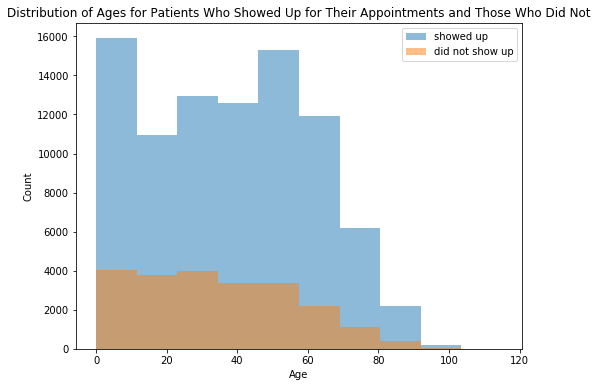

In [22]:
#create a histogram for distribution of ages in both groups
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_s['age'], alpha=0.5, label ='showed up')
ax.hist(df_n['age'], alpha=0.5, label ='did not show up')
ax.set_title('Distribution of Ages for Patients Who Showed Up for Their Appointments and Those Who Did Not')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend(loc='upper right')
plt.show()

This visual suggests that there's a difference between the distribution of ages for patients who show up for their appointments and those who don't. We don't yet have the tools to conclude that these two distributions are different or whether age definitely affects patients' showing up. However, we can observe from summary statistics and these histograms that younger patients generally tend to show up for their appointments more frequently. In particular, there seems to be a higher probability for children under 5 and patients in their 50's to show up.

### Research Question 2. Do patients who receive sms about their appointments show up more often?

In [23]:
#check mean for patients who showed up and received an sms
df_s['sms_received'].mean()

0.29133742220005215

In [24]:
#check mean for patients who didn't show up even though they received an sms
df_n['sms_received'].mean()

0.43837089475334917

In [25]:
#print a takeaway for mean values
print('{0:.2%} of patients who showed up for their appointments have received sms, while {1:.2%} of those who did not show up have received sms.'.format(df_s['sms_received'].mean(), df_n['sms_received'].mean()))

29.13% of patients who showed up for their appointments have received sms, while 43.84% of those who did not show up have received sms.


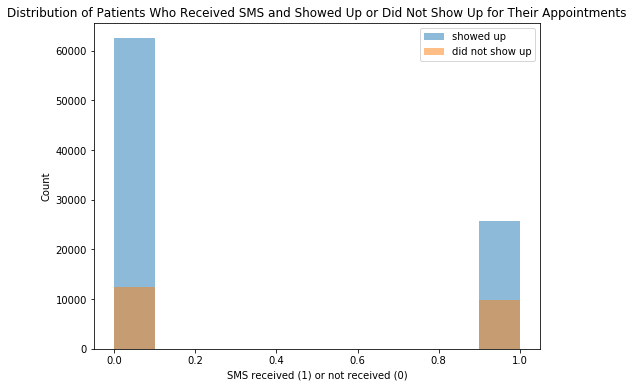

In [26]:
#create a histogram for distribution of data on sms_received in both groups
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_s['sms_received'], alpha=0.5, label ='showed up')
ax.hist(df_n['sms_received'], alpha=0.5, label ='did not show up')
ax.set_title('Distribution of Patients Who Received SMS and Showed Up or Did Not Show Up for Their Appointments')
ax.set_xlabel('SMS received (1) or not received (0)')
ax.set_ylabel('Count')
ax.legend(loc='upper right')
plt.show()

This visual suggests that an approximately equal number of people who both received and didn't receive SMS did't show up for their appointments. Moreover, we can observe that a large number of patients who didn't receive an SMS did show up for their appointment. We don't yet have the tools to conclude that these two distributions are different or whether sending SMS definitely affects patients' showing up. However, we can observe from summary statistics and these histograms that receiving sms doesn't seem to have a positive impact on patients' showing up. 

### Research Question 3. Do patients tend to make for their appointments on specific days of the week?

In [27]:
#create a column with day of the week for the appointment_day
df['day_of_week'] = df.appointment_day.dt.day_name()

#confirm changes
df.head(1)

,appointment_id,appointment_day,age,sms_received,no_show,day_of_week
0,5642903,2016-04-29,62,0,0,Friday


In [28]:
#find distribution of the days of the week for all appointments
df['day_of_week'].value_counts()

Friday    110526
Name: day_of_week, dtype: int64

We can see that there are no appointments on Sundays and very few on Saturdays. The majority of appointments are made for Wednesdays and Tuesdays.

In [29]:
#find distribution of the days of the week for the appointments patients showed up for
df.day_of_week[showed_up].value_counts()

Friday    88207
Name: day_of_week, dtype: int64

Judging from summary statistics only, the distribution of week days for the appointments that took place seems to be completely the same as for the whole data set.

In [30]:
#find distribution of the days of the week for the appointments patients didn't show up for
df.day_of_week[did_not_show_up].value_counts()

Friday    22319
Name: day_of_week, dtype: int64

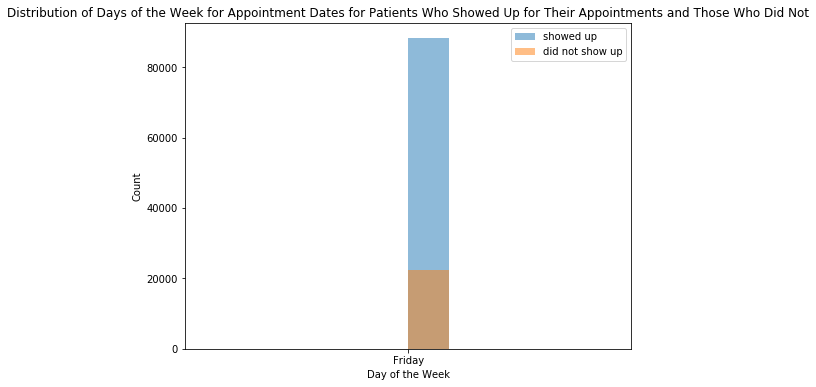

In [31]:
#create a histogram for distribution of data on days of the week in both groups
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df.day_of_week[showed_up], alpha=0.5, label ='showed up')
ax.hist(df.day_of_week[did_not_show_up], alpha=0.5, label ='did not show up')
ax.set_title('Distribution of Days of the Week for Appointment Dates for Patients Who Showed Up for Their Appointments and Those Who Did Not')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Count')
ax.legend(loc='upper right')
plt.show()


We don't yet have enough tools to conclude that these two distributions are different or whether day of the week is an important factor in predicting whether a patient will show up for their appointment. However, we can observe from summary statistics and these histograms that day of the week doesn't seem to influence patients' showing up much. The majority of appointments both did and didn't take place on weekdays, not weekends, with the majority on Wednesdays and Tuesdays.  

<a id='conclusions'></a>
## Conclusions

Let's sum up our findings and identify factors which are important in predicting if a patient will show up for their scheduled appointment. We'll be using some heuristic based on our exploration, however getting a prediction this way comes with limitations. To begin with, we looked at very limited piecies of information, and various factors can have multiple interactions with each other. Moreover, machine learning is a much better way to make predictions automatically, so we'll keep in mind that these conclusions are limited to our observations made "by hand."

Let's address the initial questions one by one:

### 1. Are patients of certain age more likely to show up for their appointments?

Keeping all the limitations in mind, we can observe from summary statistics and histograms that younger patients generally tend to show up for their appointments more frequently. In particular, there seems to be a higher probability for children under 5 and patients in their 50's to show up.

### 2. Do patients who receive sms about their appointments show up more often?

Keeping all the limitations in mind, we can observe from summary statistics and histograms that an approximately equal number of people who both received and didn't receive SMS didn't show up for their appointments. Thus, receiving sms doesn't seem to have a positive impact on patients' showing up.

### 3. Do patients tend to make for their appointments on specific days of the week? 

Keeping all the limitations in mind, we can observe from summary statistics and histograms that day of the week doesn't seem to influence patients' showing up much. The majority of appointments both did and didn't take place on weekdays, not weekends, with the majority being set on Wednesdays and Tuesdays. 
